In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time


In [2]:
def stitch_image(img1, img2, H):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    img1_dims = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    img2_dims = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    img1_transform = cv2.perspectiveTransform(img1_dims, H)
    result_dims = np.concatenate((img2_dims, img1_transform), axis=0)
    [x_min, y_min] = np.int32(result_dims.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(result_dims.max(axis=0).ravel() + 0.5)
    transform_dist = [-x_min, -y_min]
    transform_array = np.array([[1, 0, transform_dist[0]],
                                [0, 1, transform_dist[1]],
                                [0, 0, 1]])
    result_img = cv2.warpPerspective(img1, transform_array.dot(H), (x_max - x_min, y_max - y_min))
    result_img[transform_dist[1]:transform_dist[1] + h2, transform_dist[0]:transform_dist[0] + w2] = img2
    print(f"拼接后图像尺寸：{result_img.shape}")
    return result_img

In [3]:
def get_homo(img1, img2):
    sift = cv2.SIFT_create()
    k1, d1 = sift.detectAndCompute(img1, None)
    k2, d2 = sift.detectAndCompute(img2, None)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(d1, d2, k=2)
    verify_ratio = 0.8
    verify_matches = [m1 for m1, m2 in matches if m1.distance < verify_ratio * m2.distance]
    print(f"匹配点对数量：{len(verify_matches)}")
    if len(verify_matches) > 8:
        img1_pts = np.float32([k1[m.queryIdx].pt for m in verify_matches]).reshape(-1, 1, 2)
        img2_pts = np.float32([k2[m.trainIdx].pt for m in verify_matches]).reshape(-1, 1, 2)
        H, _ = cv2.findHomography(img1_pts, img2_pts, cv2.RANSAC, 5.0)
        print(f"计算的单应性矩阵：\n{H}")
        return H
    else:
        raise ValueError("匹配点对数量不足，无法计算单应性矩阵！")

In [4]:
def main(img1, img2):
    start_time = time.time()

    img1 = cv2.resize(img1, (640, 480))
    img2 = cv2.resize(img2, (640, 480))
    print(f"图像 1 尺寸：{img1.shape}")
    print(f"图像 2 尺寸：{img2.shape}")

    sift = cv2.SIFT_create()
    keypoints1, des1 = sift.detectAndCompute(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), None)
    keypoints2, des2 = sift.detectAndCompute(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), None)
    print(f"图像 1 特征点数量：{len(keypoints1)}")
    print(f"图像 2 特征点数量：{len(keypoints2)}")

    img1_with_keypoints = cv2.drawKeypoints(img1, keypoints1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    img2_with_keypoints = cv2.drawKeypoints(img2, keypoints2, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("feature 1")
    plt.imshow(cv2.cvtColor(img1_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("feature 2")
    plt.imshow(cv2.cvtColor(img2_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    try:
        H = get_homo(img1, img2)
        stitched_image = stitch_image(img1, img2, H)

        plt.figure(figsize=(10, 10))
        plt.title("result img")
        plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    except ValueError as e:
        print(f"错误：{e}")

    end_time = time.time()
    processing_time = end_time - start_time
    frame_rate = 1 / processing_time
    print(f"处理时间：{processing_time:.2f} 秒")
    print(f"帧率：{frame_rate:.2f} FPS")

图像 1 尺寸：(480, 640, 3)
图像 2 尺寸：(480, 640, 3)
图像 1 特征点数量：2458
图像 2 特征点数量：2772


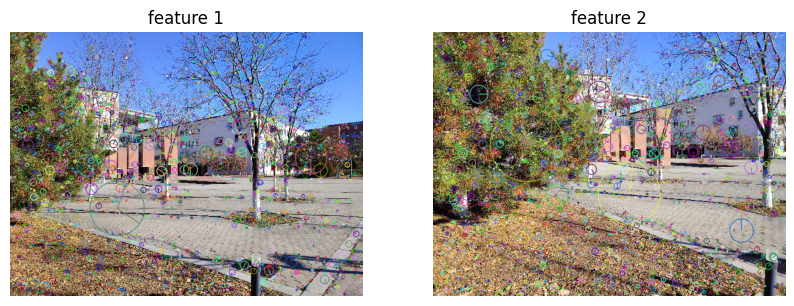

匹配点对数量：236
计算的单应性矩阵：
[[ 6.13859933e-01  6.47653492e-02  1.55807686e+02]
 [-1.50018449e-01  8.79683814e-01  5.35211824e+00]
 [-6.21336311e-04  6.58953925e-05  1.00000000e+00]]
拼接后图像尺寸：(674, 914, 3)


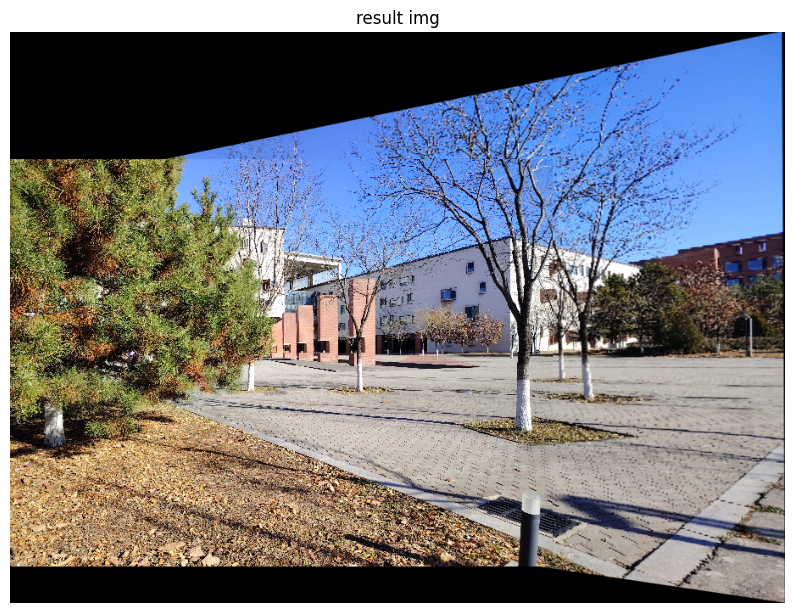

处理时间：1.29 秒
帧率：0.77 FPS
图像 1 尺寸：(480, 640, 3)
图像 2 尺寸：(480, 640, 3)
图像 1 特征点数量：160
图像 2 特征点数量：97


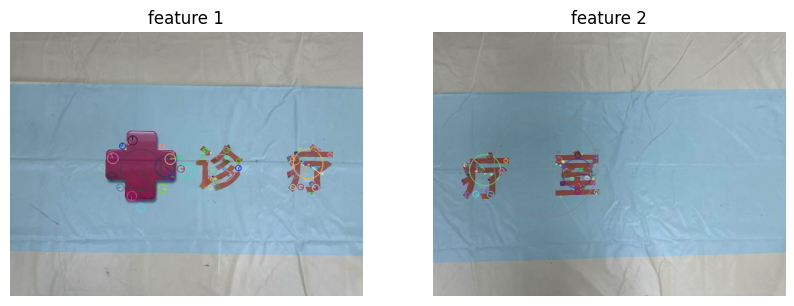

匹配点对数量：39
计算的单应性矩阵：
[[ 8.99078866e-01 -3.33155241e-02 -3.95162902e+02]
 [-5.85253698e-02  8.78457932e-01  4.95292405e+01]
 [-1.14714610e-04 -1.30327566e-04  1.00000000e+00]]
拼接后图像尺寸：(503, 1079, 3)


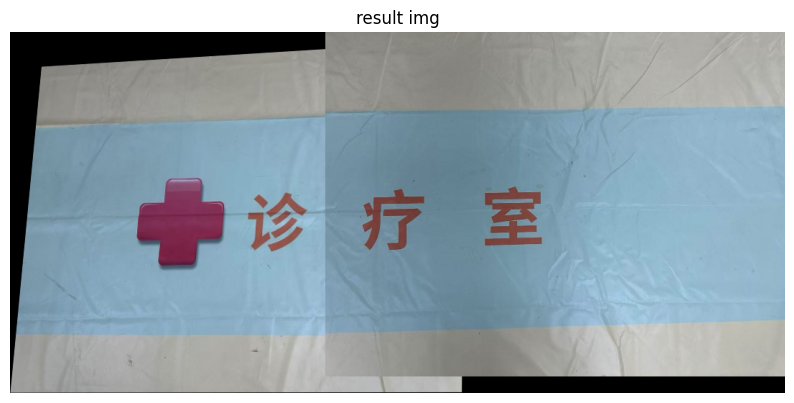

处理时间：0.77 秒
帧率：1.30 FPS


In [5]:
img1 = cv2.imread("3.jpg")
img2 = cv2.imread("4.jpg")
img3 = cv2.imread("8.jpg")
img4 = cv2.imread("9.jpg")

main(img1, img2)
main(img3, img4)
